/Users/saitcakmak/PycharmProjects/robust_mobo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.


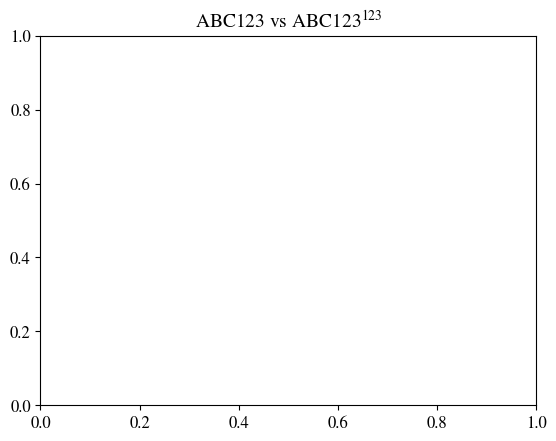

In [1]:
import torch
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.font_manager
from matplotlib.lines import Line2D
from matplotlib import rc
import matplotlib
from math import sqrt

import json
%matplotlib inline

rc('font', family='serif', style='normal', variant='normal', weight='normal', stretch='normal', size=8)
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
matplotlib.style.use('default')
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}\usepackage{bm}"]

In [2]:
exp_dir = "../experiments/experiment_v1/"
max_hv_dir = "./max_hvs/"

In [14]:
from matplotlib.ticker import FormatStrFormatter

cmap = matplotlib.cm.get_cmap('rainbow')

plot_args = {
    "sobol": {"label": "Sobol", "color": "tab:pink"},
    "nsgaii": {"label": "NSGA-II", "color": "tab:green"},
    "nparego": {"label": "qNParEGO", "color": "tab:brown"},
    "nehvi": {"label": "qNEHVI", "color": "tab:gray"},
    "expectation_nparego": {"label": "Exp-qNParEGO", "color": "tab:olive"},
    "ref_ch-var-nei": {"label": "MARS-NEI", "color": "tab:red"},
}
labels = list(plot_args.keys())
N_REPS = 20
verbose = True
shade_alpha = 0.1
plot_regret = True
plot_log = True
default_figsize = (5, 4.5)
legend_cols = 1
use_legend: bool = True
min_iter = 100
min_reps = 5


def plot(
    problem, q=1, max_hv_name: str = None, title=None, marker=None, fig=None, ax=None,
    suffix: str = "", markerevery: int = 1,
):
    if plot_regret:
        if max_hv_name is None:
            max_hv_name = problem
        max_hv = torch.load(
            os.path.join(max_hv_dir, f"{max_hv_name}.pt")
        )["max_hv"]
    agg_results = {}
    for label in labels:
        for seed in range(N_REPS):
            path = os.path.join(exp_dir, problem, label, f"{str(seed).zfill(4)}_{label}.pt")
            try:
                res = torch.load(path, map_location="cpu")
            except (FileNotFoundError, EOFError):
                if verbose:
                    print(f"No file found, skipping: {os.path.basename(path)}!")
                continue
            if label not in agg_results:
                agg_results[label] = {k: (v.unsqueeze(0) if torch.is_tensor(v) else v) for k,v in res.items()}
            else:
                label_res = agg_results[label]
                for k,v in res.items():
                    if torch.is_tensor(v):
                        if v.shape[0] < min_iter and label != "nsgaii":
                            if verbose:
                                print(f"Insufficient iterations, skipping: {os.path.basename(path)}!")
                            break
                        if v.shape[0] != label_res[k].shape[1]:
                            # partial result
                            max_iter = min(label_res[k].shape[1], v.shape[0])
                            label_res[k] = label_res[k][:, :max_iter]
                            v = v[:max_iter]
                        label_res[k] = torch.cat([label_res[k], v.unsqueeze(0)], dim=0)
    using_existing_fig = fig is not None
    if fig is None and ax is None:
        fig, ax = plt.subplots(1, figsize=default_figsize)
    for label in labels:
        try:
            res = agg_results[label]
        except KeyError:
            continue
        hvs = res["all_mvar_hvs"]
        if hvs.shape[0] < min_reps:
            continue
        hv_mean = hvs.mean(dim=0)
        hv_sem = hvs.std(dim=0)/sqrt(hvs.shape[0])
        if plot_regret:
            hv_mean = max_hv - hv_mean
        # ax.errorbar(np.arange(hv_mean.shape[0]), hv_mean, yerr=hv_sem, label=label)
        x = np.arange(hv_mean.shape[0]) * q
        if label == "nsgaii":
            x *= 10
        if plot_log:
            ax.plot(x, hv_mean.log10(), **plot_args[label], marker=marker, markevery=markerevery)
            ax.fill_between(x, (hv_mean-2*hv_sem).log10(), (hv_mean+2*hv_sem).log10(),
                            color=plot_args[label]["color"], alpha=shade_alpha)
        else:
            ax.plot(x, hv_mean, **plot_args[label], marker=marker, markevery=markerevery)
            ax.fill_between(x, hv_mean-2*hv_sem, hv_mean+2*hv_sem,
                            color=plot_args[label]["color"], alpha=shade_alpha)
        mean_time = res['wall_time'].mean(dim=0)[-1]
        sem_time = res['wall_time'].std(dim=0)[-1] / sqrt(hvs.shape[0]) * 2
        final_mean = hv_mean[-1]
        final_2sem = hv_sem[-1] * 2
        if verbose:
            print(f"Label: {label}, num replications: {hvs.shape[0]}, time: {mean_time}, +- {sem_time} \n"
                  f"final hv (regret): {final_mean}, 2sem: {final_2sem}.")
    if title:
        ax.set_title(title)
    else:
        ax.set_title(problem)
    if use_legend:
        if plot_regret:
            ax.legend(loc=1, ncol=legend_cols)
        else:
            ax.legend(loc=4, ncol=legend_cols)
    fig.tight_layout()
    if not using_existing_fig:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_ylabel("Log MVAR HV Regret")
    ax.set_xlabel("Function Evaluations")
    if title and use_legend:
        title = title.replace("$", "")
        title = title.replace("\\", "")
        plt.savefig(f"plots/{title}{suffix}.pdf", dpi=300, bbox_inches='tight')

# MT plots

In [18]:
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 18

use_legend = False

Label: sobol, num replications: 20, time: 40.810908269882205, +- 5.888299427448508 
final hv (regret): 0.006537465329597925, 2sem: 0.0010234990480331395.
Label: nsgaii, num replications: 20, time: 0.0, +- 0.0 
final hv (regret): 0.005452347703518346, 2sem: 0.0022469162142996807.
Label: nparego, num replications: 20, time: 248.79040145874023, +- 23.15876064714409 
final hv (regret): 0.002154088313254556, 2sem: 0.0007675802515976352.
Label: nehvi, num replications: 20, time: 245.72542699575425, +- 19.92107647949255 
final hv (regret): 0.0031205694590906944, 2sem: 0.001433606229015351.
Label: expectation_nparego, num replications: 20, time: 334.3465459346771, +- 24.171256627532866 
final hv (regret): 0.0010286972541251153, 2sem: 0.00029183645436871894.
Label: ref_ch-var-nei, num replications: 20, time: 388.2894519805908, +- 29.725278567482587 
final hv (regret): 0.00014519490027278467, 2sem: 1.1500690600776304e-05.
Label: sobol, num replications: 20, time: 93.09463061094284, +- 10.1455406

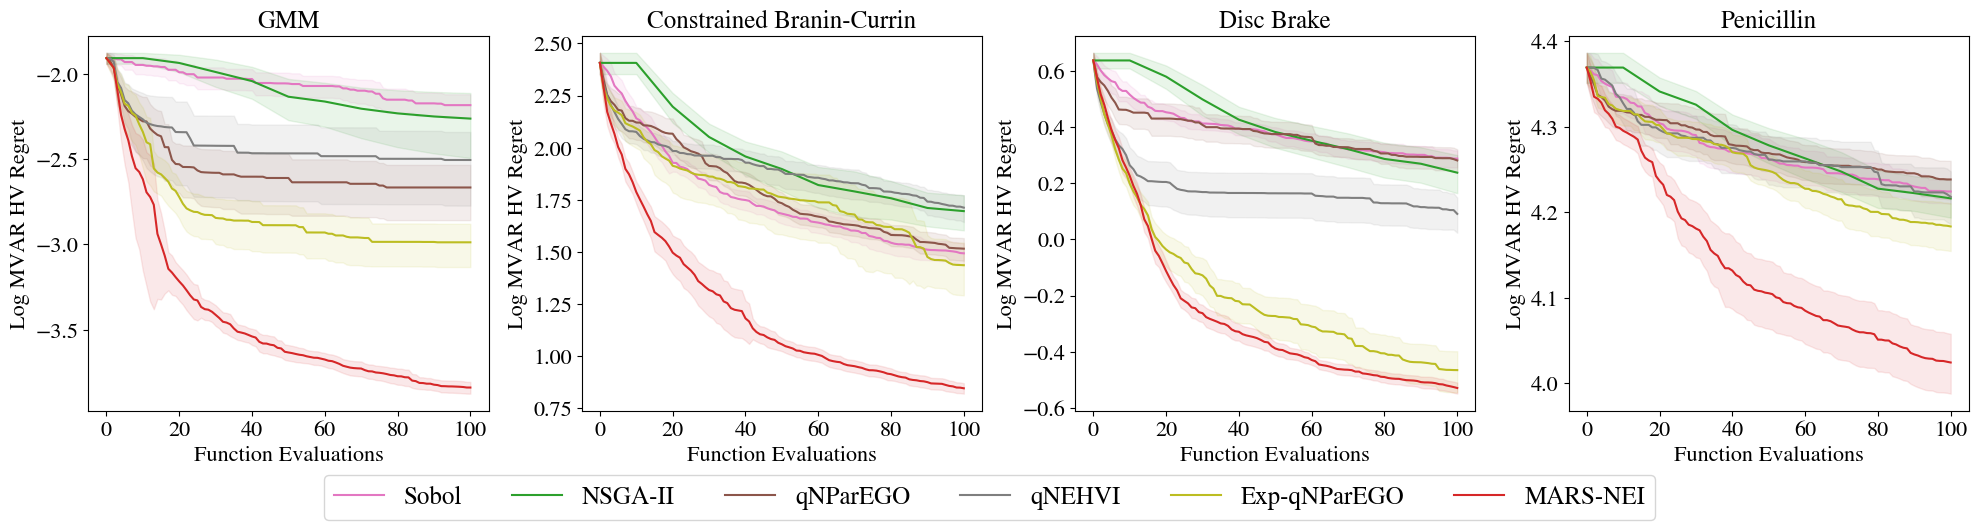

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5.4),
                         gridspec_kw={})


plot("gmm_mul", title="GMM", fig=fig, ax=axes[0])
plot("bc_heteroskedastic_v2", title="Constrained Branin-Currin", fig=fig, ax=axes[1])
plot("disc_brake", title="Disc Brake", fig=fig, ax=axes[2])
plot("penicillin_v2", title="Penicillin", fig=fig, ax=axes[3])

h, l = axes[0].get_legend_handles_labels()
leg = fig.legend(
    h,
    l,
    loc="lower center",
    ncol=6,
)

fig.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig("plots/mt_results.pdf", dpi=300, transparent=True)
plt.show()



# NEHVI based methods

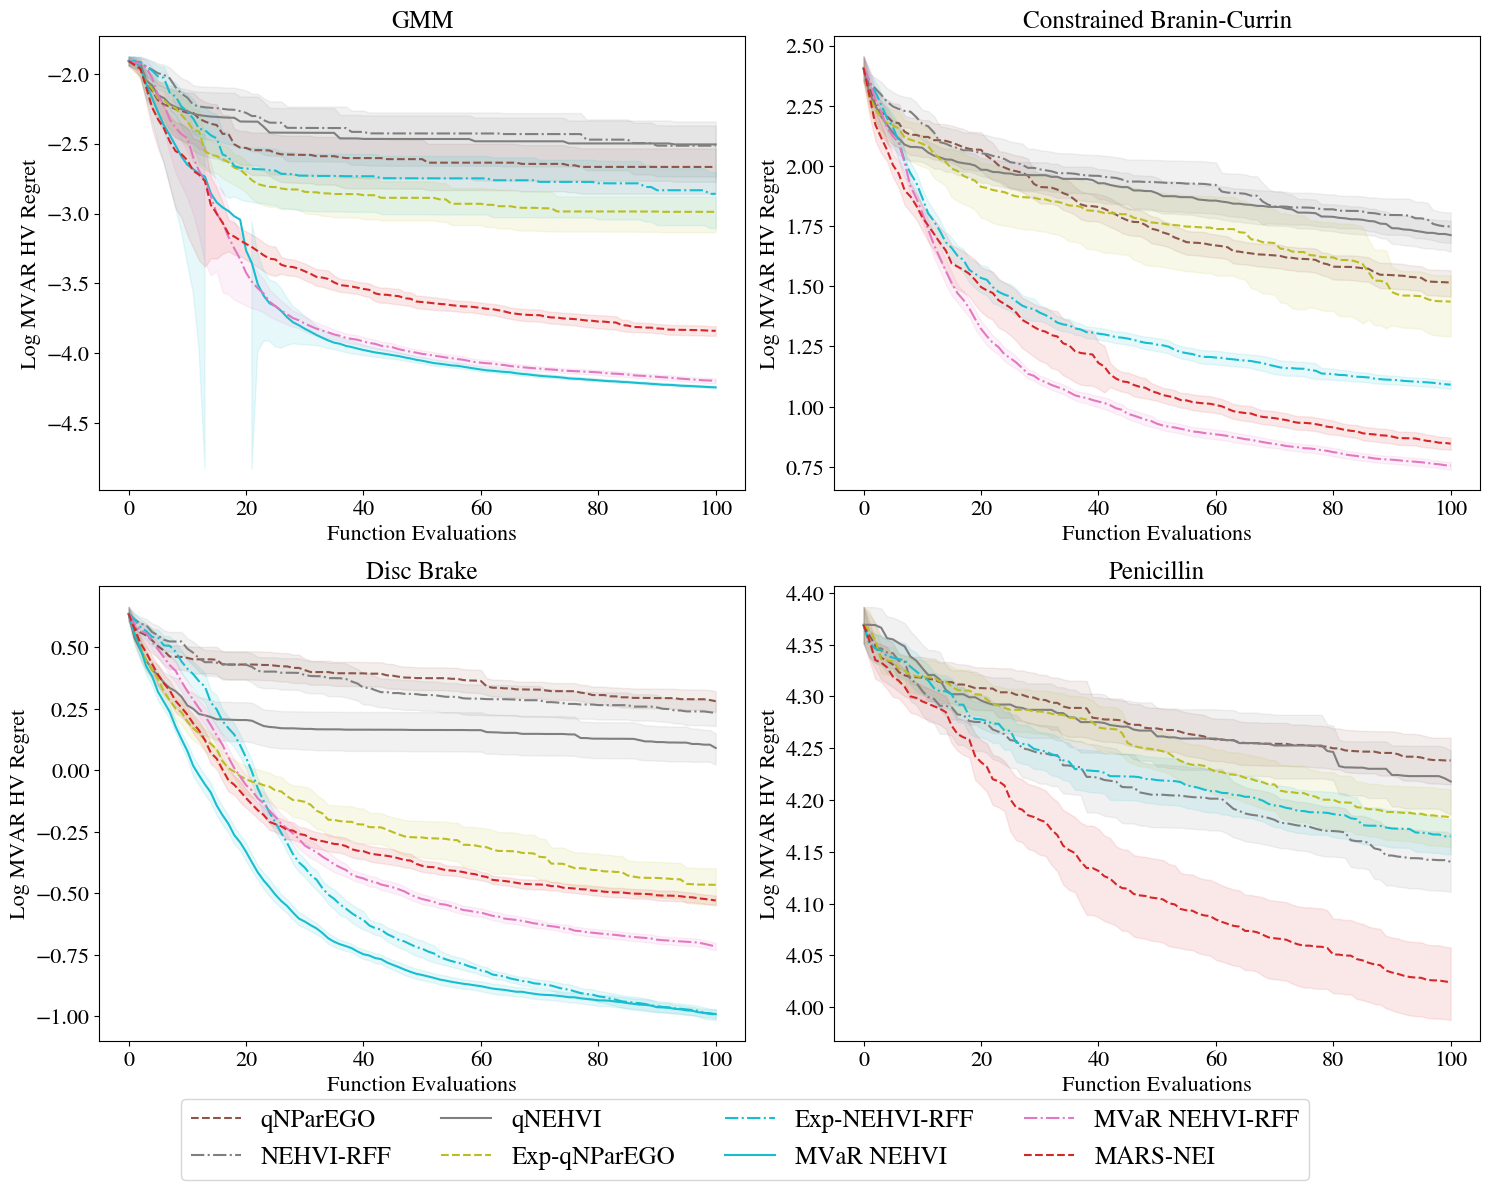

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12),
                         gridspec_kw={})

plot_args = {
    "nparego": {"label": "qNParEGO", "color": "tab:brown", "ls": "--"},
    "nehvi_rff": {"label": "NEHVI-RFF", "color": "tab:gray", "ls": "-."},
    "nehvi": {"label": "qNEHVI", "color": "tab:gray"},
    "expectation_nparego": {"label": "Exp-qNParEGO", "color": "tab:olive", "ls": "--"},
    "expectation_nehvi_rff": {"label": "Exp-NEHVI-RFF", "color": "tab:cyan", "ls": "-."},
    "ref_mvar_nehvi": {"label": "MVaR NEHVI", "color": "tab:cyan", "ls": "-"},
    "ref_mvar_nehvi_rff": {"label": "MVaR NEHVI-RFF", "color": "tab:pink", "ls": "-."},
    "ref_ch-var-nei": {"label": "MARS-NEI", "color": "tab:red", "ls": "--"},
}
labels = list(plot_args.keys())

plot("gmm_mul", title="GMM", fig=fig, ax=axes[0, 0])
plot("bc_heteroskedastic_v2", title="Constrained Branin-Currin", fig=fig, ax=axes[0, 1])
plot("disc_brake", title="Disc Brake", fig=fig, ax=axes[1, 0])
plot("penicillin_v2", title="Penicillin", fig=fig, ax=axes[1, 1])

h, l = axes[0, 0].get_legend_handles_labels()
leg = fig.legend(
    h,
    l,
    loc="lower center",
    ncol=4,
)

fig.tight_layout(rect=[0, 0.07, 1, 1])
plt.savefig("plots/nehvi_methods.pdf", dpi=300, transparent=True)
plt.show()

# All methods optimizing MVaR

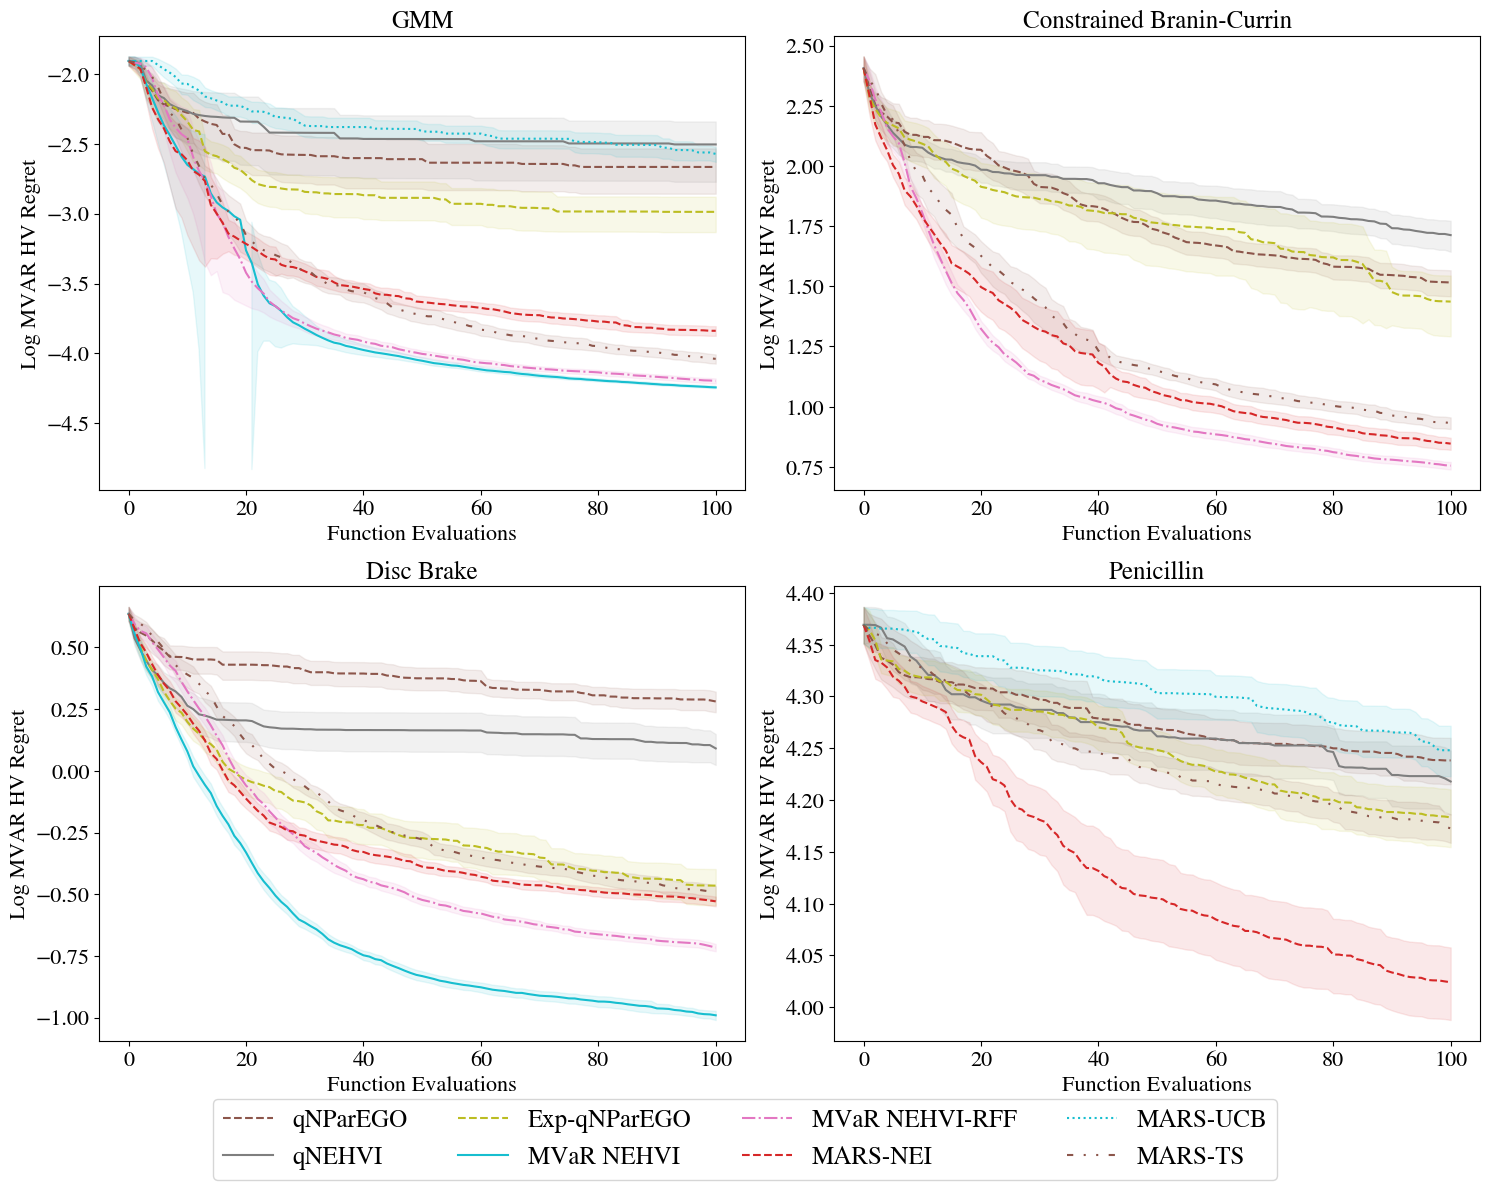

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12),
                         gridspec_kw={})

plot_args = {
    "nparego": {"label": "qNParEGO", "color": "tab:brown", "ls": "--"},
    "nehvi": {"label": "qNEHVI", "color": "tab:gray"},
    "expectation_nparego": {"label": "Exp-qNParEGO", "color": "tab:olive", "ls": "--"},
    "ref_mvar_nehvi": {"label": "MVaR NEHVI", "color": "tab:cyan", "ls": "-"},
    "ref_mvar_nehvi_rff": {"label": "MVaR NEHVI-RFF", "color": "tab:pink", "ls": "-."},
    "ref_ch-var-nei": {"label": "MARS-NEI", "color": "tab:red", "ls": "--"},
    "ch-var-ucb": {"label": "MARS-UCB", "color": "tab:cyan", "ls": ":"},
    "ref_ch-var-ts": {"label": "MARS-TS", "color": "tab:brown", "ls": (0, (3, 5, 1, 5, 1, 5))},
}
labels = list(plot_args.keys())

plot("gmm_mul", title="GMM", fig=fig, ax=axes[0, 0])
plot("bc_heteroskedastic_v2", title="Constrained Branin-Currin", fig=fig, ax=axes[0, 1])
plot("disc_brake", title="Disc Brake", fig=fig, ax=axes[1, 0])
plot("penicillin_v2", title="Penicillin", fig=fig, ax=axes[1, 1])

h, l = axes[0, 0].get_legend_handles_labels()
leg = fig.legend(
    h,
    l,
    loc="lower center",
    ncol=4,
)

fig.tight_layout(rect=[0, 0.07, 1, 1])
plt.savefig("plots/mvar_methods.pdf", dpi=300, transparent=True)
plt.show()

## Others, single plot

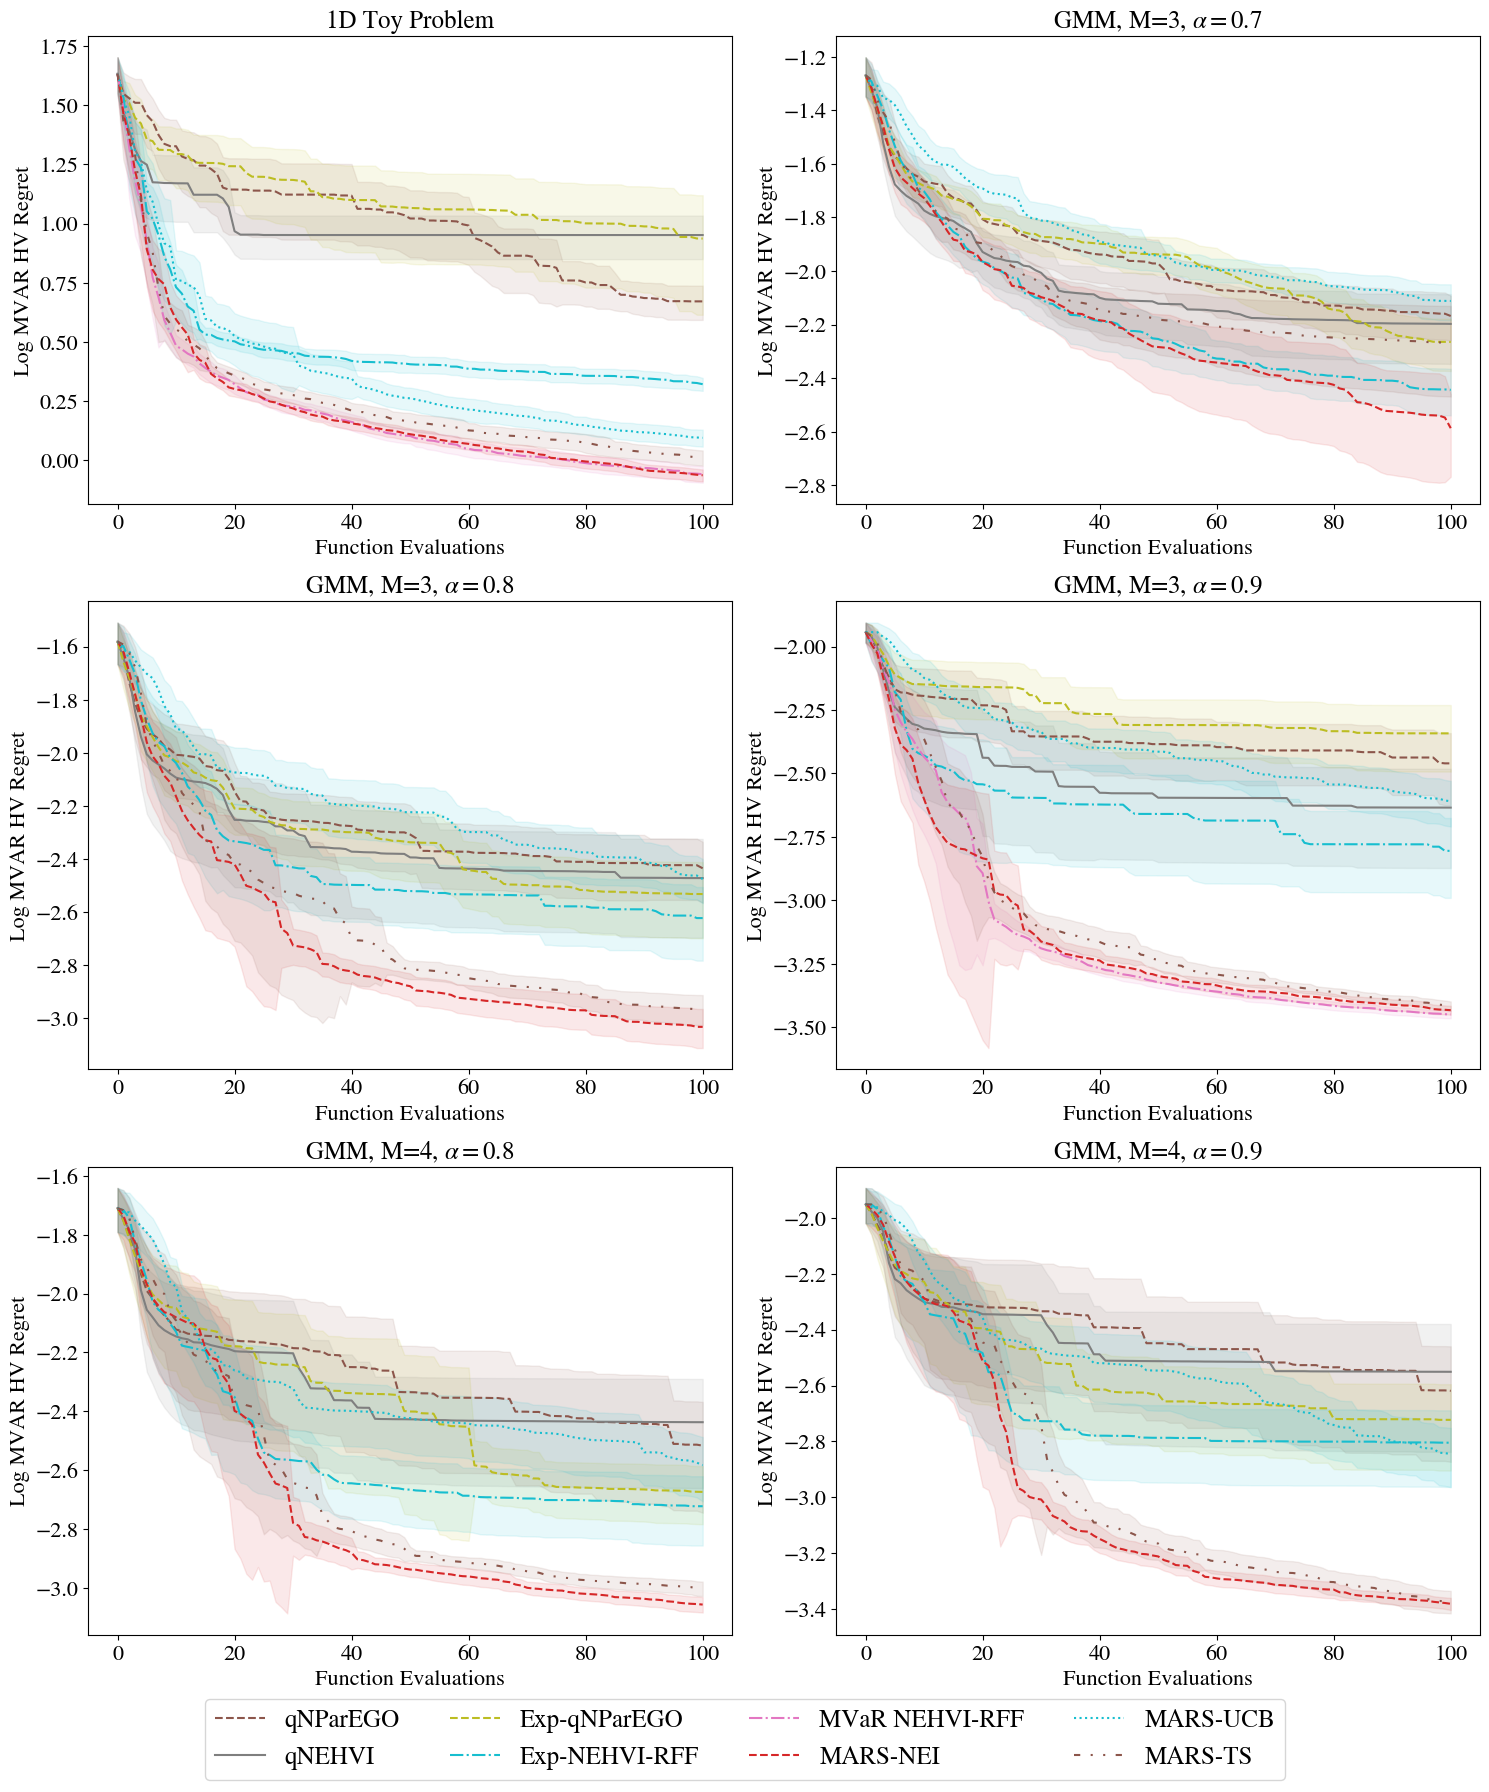

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18),
                         gridspec_kw={})

plot_args = {
    # "sobol": {"label": "Sobol", "color": "tab:pink"},
    "nparego": {"label": "qNParEGO", "color": "tab:brown", "ls": "--"},
    "nehvi": {"label": "qNEHVI", "color": "tab:gray"},
    # "cas": {"label": "Constraint Active Search", "color": "tab:pink"},
    # "nehvi_rff": {"label": "NEHVI-RFF", "color": "tab:gray", "ls": "-."},
    "expectation_nparego": {"label": "Exp-qNParEGO", "color": "tab:olive", "ls": "--"},
    "expectation_nehvi_rff": {"label": "Exp-NEHVI-RFF", "color": "tab:cyan", "ls": "-."},
    "ref_mvar_nehvi_rff": {"label": "MVaR NEHVI-RFF", "color": "tab:pink", "ls": "-."},
    "ref_ch-var-nei": {"label": "MARS-NEI", "color": "tab:red", "ls": "--"},
    "ch-var-ucb": {"label": "MARS-UCB", "color": "tab:cyan", "ls": ":"},
    "ref_ch-var-ts": {"label": "MARS-TS", "color": "tab:brown", "ls": (0, (3, 5, 1, 5, 1, 5))},
}
labels = list(plot_args.keys())

plot("1d_toy", title="1D Toy Problem", fig=fig, ax=axes[0, 0])
plot("gmm3_07", title=r"GMM, M=3, $\alpha = 0.7$", fig=fig, ax=axes[0, 1])
plot("gmm3_08", title=r"GMM, M=3, $\alpha = 0.8$", fig=fig, ax=axes[1, 0])
plot("gmm3", title=r"GMM, M=3, $\alpha = 0.9$", fig=fig, ax=axes[1, 1])
plot("gmm_4obj_08", title=r"GMM, M=4, $\alpha = 0.8$", fig=fig, ax=axes[2, 0])
plot("gmm_4obj", title=r"GMM, M=4, $\alpha = 0.9$", fig=fig, ax=axes[2, 1])

h, l = axes[0, 0].get_legend_handles_labels()
leg = fig.legend(
    h,
    l,
    loc="lower center",
    ncol=4,
)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("plots/additional_exps_single.pdf", dpi=300, transparent=True)
plt.show()

## Separate Toy and GMMs

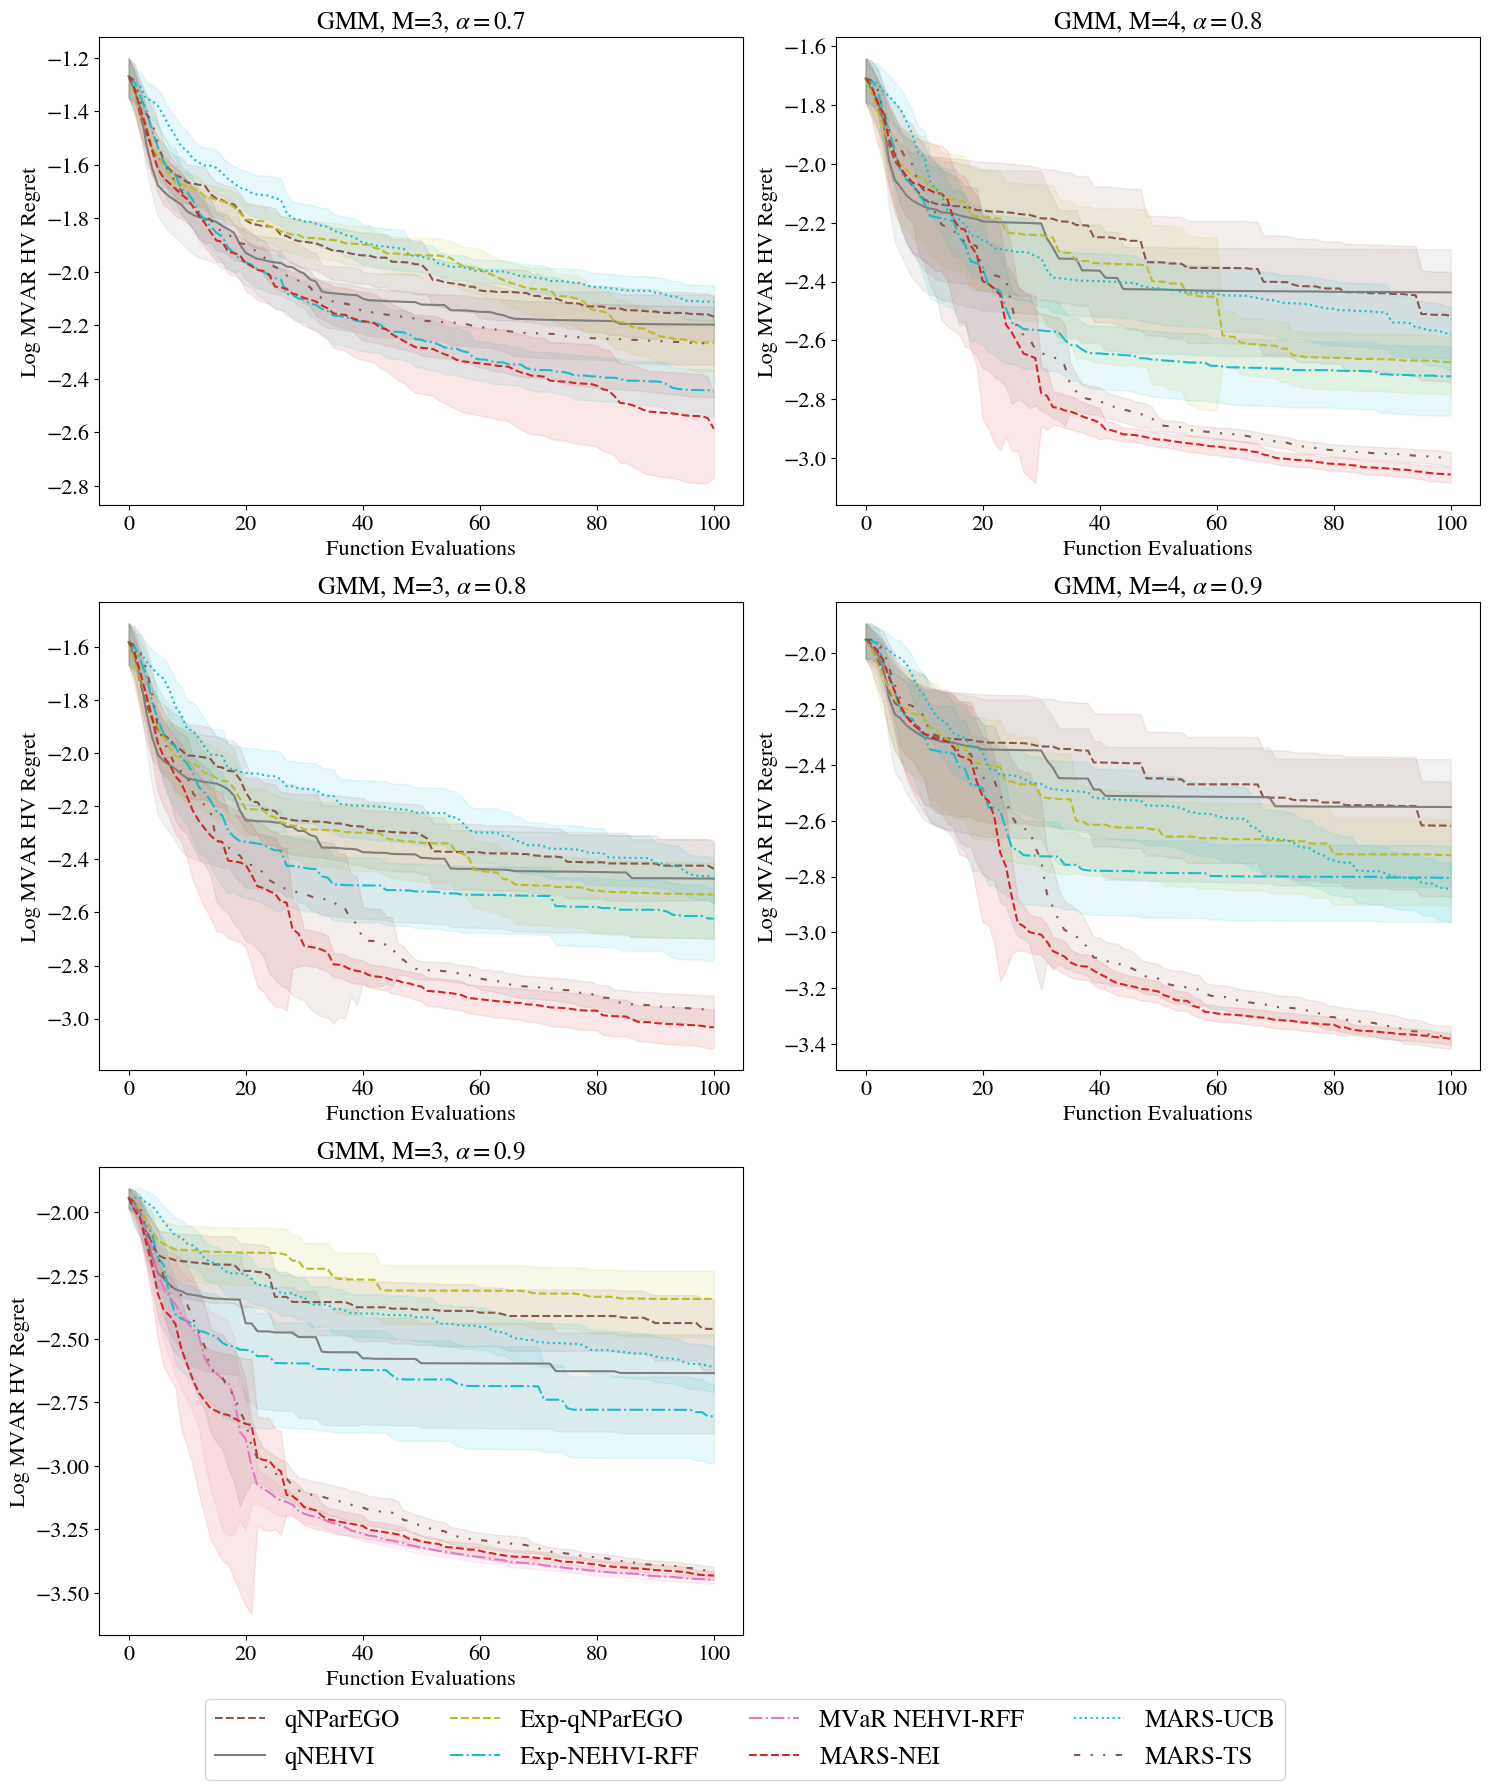

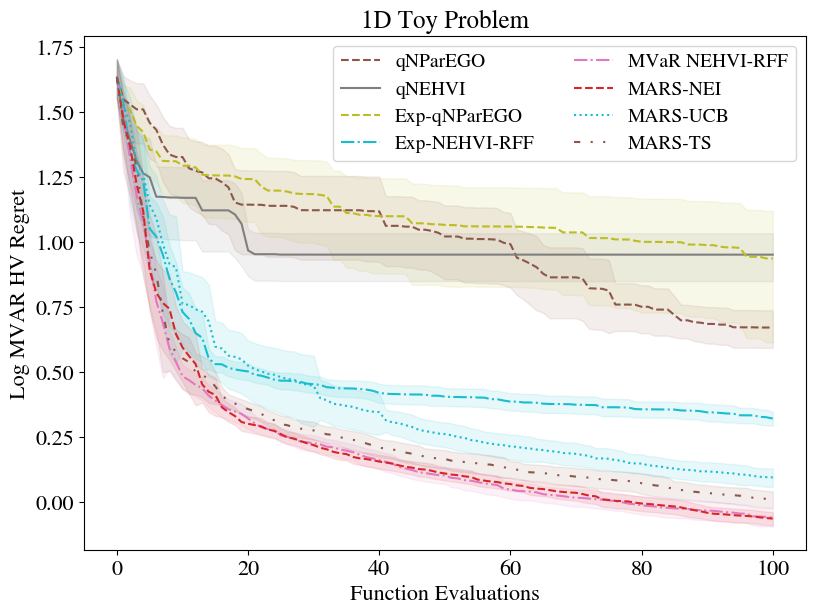

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18),
                         gridspec_kw={})

plot_args = {
    # "sobol": {"label": "Sobol", "color": "tab:pink"},
    "nparego": {"label": "qNParEGO", "color": "tab:brown", "ls": "--"},
    "nehvi": {"label": "qNEHVI", "color": "tab:gray"},
    # "cas": {"label": "Constraint Active Search", "color": "tab:pink"},
    # "nehvi_rff": {"label": "NEHVI-RFF", "color": "tab:gray", "ls": "-."},
    "expectation_nparego": {"label": "Exp-qNParEGO", "color": "tab:olive", "ls": "--"},
    "expectation_nehvi_rff": {"label": "Exp-NEHVI-RFF", "color": "tab:cyan", "ls": "-."},
    "ref_mvar_nehvi_rff": {"label": "MVaR NEHVI-RFF", "color": "tab:pink", "ls": "-."},
    "ref_ch-var-nei": {"label": "MARS-NEI", "color": "tab:red", "ls": "--"},
    "ch-var-ucb": {"label": "MARS-UCB", "color": "tab:cyan", "ls": ":"},
    "ref_ch-var-ts": {"label": "MARS-TS", "color": "tab:brown", "ls": (0, (3, 5, 1, 5, 1, 5))},
}
labels = list(plot_args.keys())

plot("gmm3_07", title=r"GMM, M=3, $\alpha = 0.7$", fig=fig, ax=axes[0, 0])
plot("gmm3_08", title=r"GMM, M=3, $\alpha = 0.8$", fig=fig, ax=axes[1, 0])
plot("gmm3", title=r"GMM, M=3, $\alpha = 0.9$", fig=fig, ax=axes[2, 0])
plot("gmm_4obj_08", title=r"GMM, M=4, $\alpha = 0.8$", fig=fig, ax=axes[0, 1])
plot("gmm_4obj", title=r"GMM, M=4, $\alpha = 0.9$", fig=fig, ax=axes[1, 1])

fig.delaxes(axes[2, 1])

h, l = axes[2, 0].get_legend_handles_labels()
leg = fig.legend(
    h,
    l,
    loc="lower center",
    ncol=4,
)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("plots/additional_exps_gmm.pdf", dpi=300, transparent=True)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6),
                         gridspec_kw={})

use_legend = True
legend_cols = 2
matplotlib.rcParams['legend.fontsize'] = 14
plot("1d_toy", title="1D Toy Problem", fig=fig, ax=axes)
matplotlib.rcParams['legend.fontsize'] = 18
legend_cols = 1
use_legend = False
plt.savefig("plots/additional_exps_toy.pdf", dpi=300, transparent=True, bbox_inches='tight')


## GMM noise comparisons

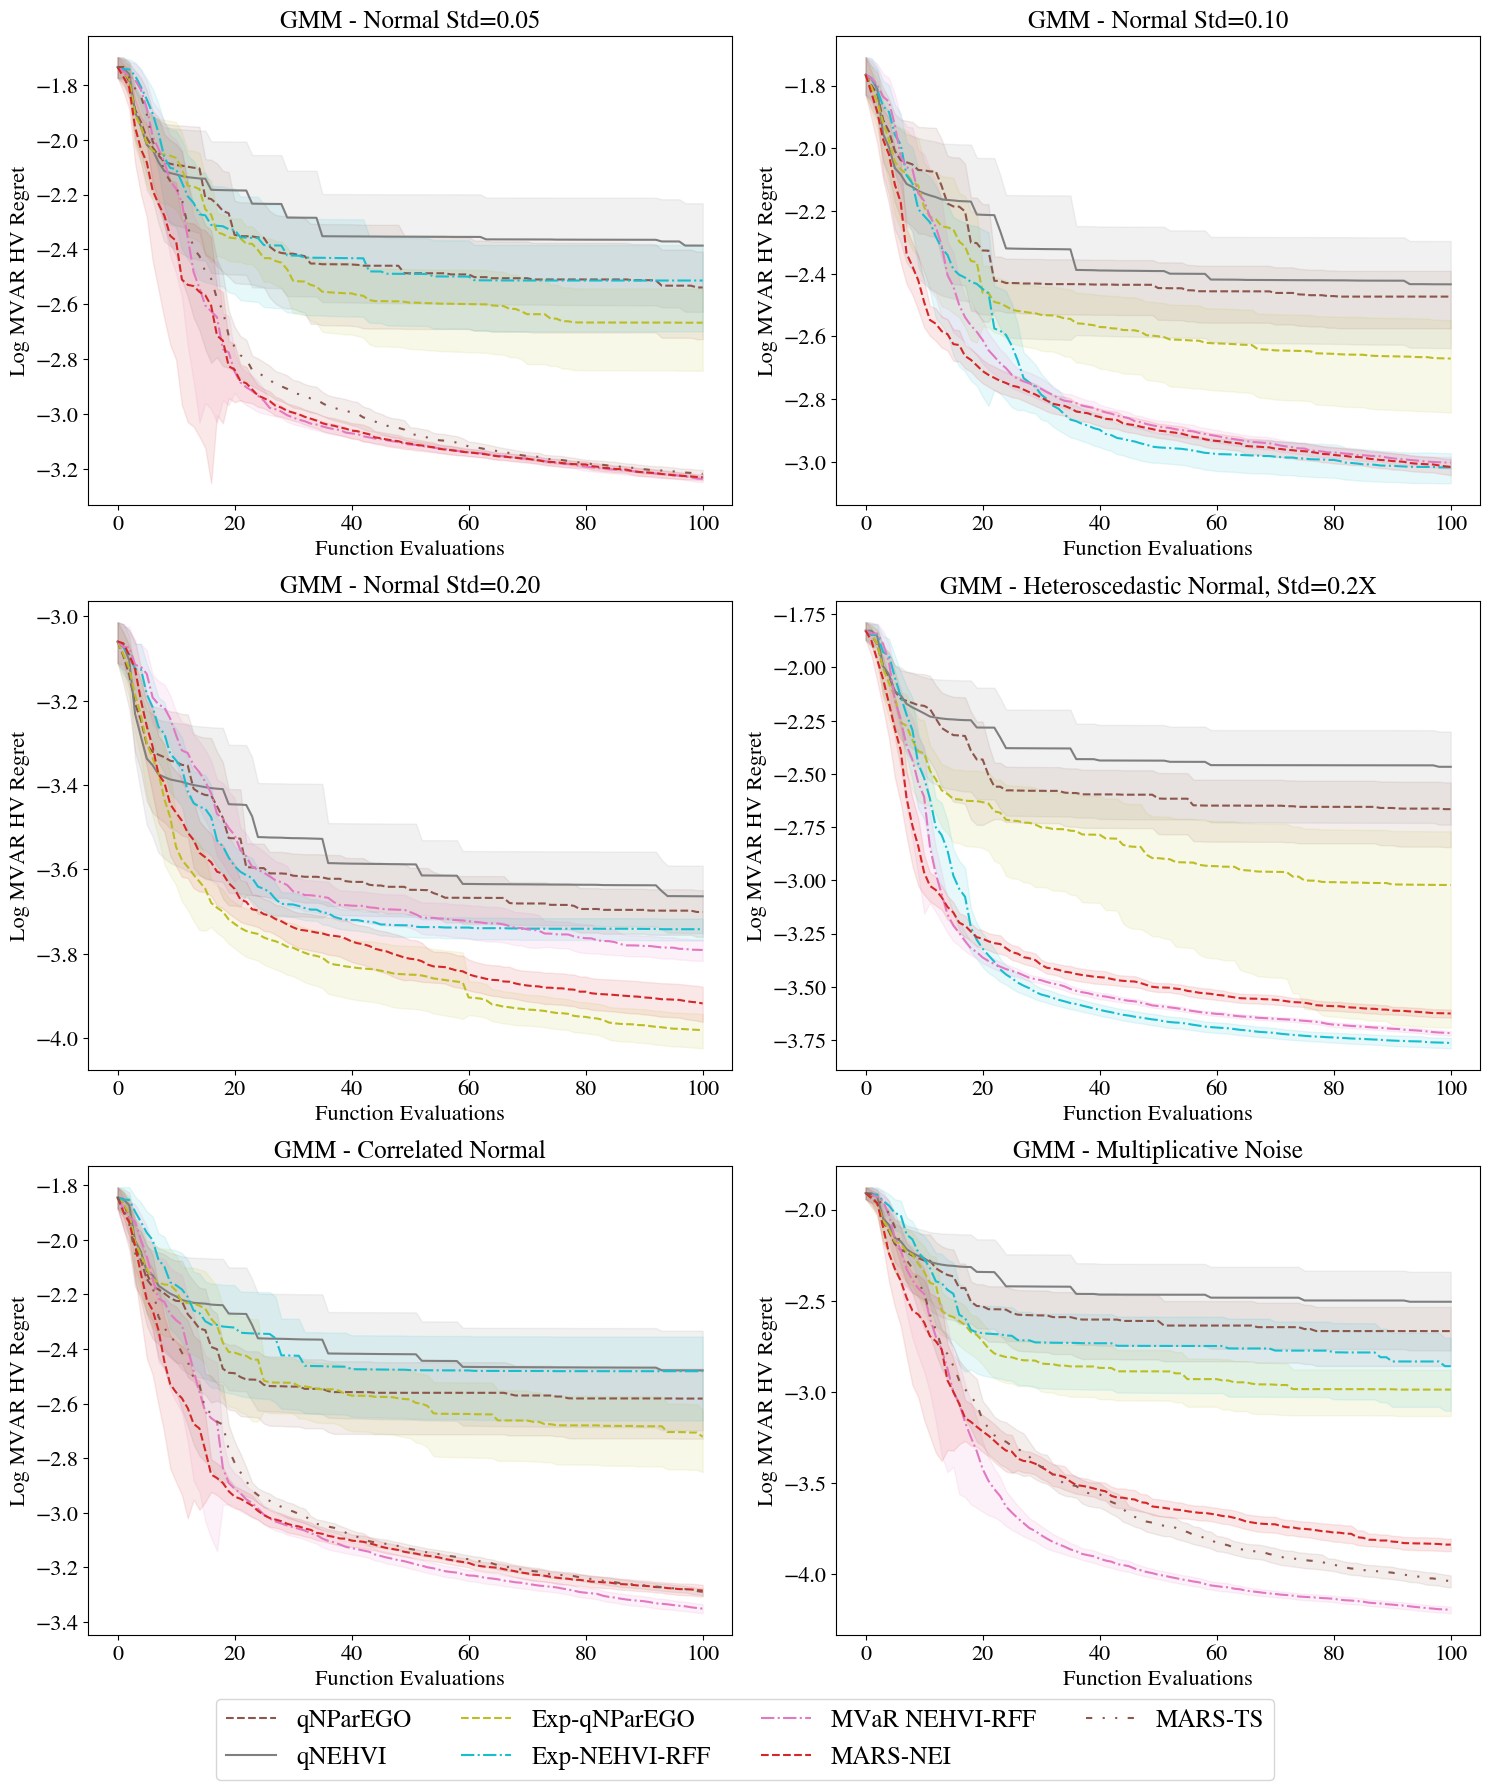

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18),
                         gridspec_kw={})

plot_args = {
    # "sobol": {"label": "Sobol", "color": "tab:pink"},
    "nparego": {"label": "qNParEGO", "color": "tab:brown", "ls": "--"},
    "nehvi": {"label": "qNEHVI", "color": "tab:gray"},
    # "cas": {"label": "Constraint Active Search", "color": "tab:pink"},
    # "nehvi_rff": {"label": "NEHVI-RFF", "color": "tab:gray", "ls": "-."},
    "expectation_nparego": {"label": "Exp-qNParEGO", "color": "tab:olive", "ls": "--"},
    "expectation_nehvi_rff": {"label": "Exp-NEHVI-RFF", "color": "tab:cyan", "ls": "-."},
    "ref_mvar_nehvi_rff": {"label": "MVaR NEHVI-RFF", "color": "tab:pink", "ls": "-."},
    "ref_ch-var-nei": {"label": "MARS-NEI", "color": "tab:red", "ls": "--"},
    # "ch-var-ucb": {"label": "MARS-UCB", "color": "tab:cyan", "ls": ":"},
    "ref_ch-var-ts": {"label": "MARS-TS", "color": "tab:brown", "ls": (0, (3, 5, 1, 5, 1, 5))},
}
labels = list(plot_args.keys())

plot("gmm_demo", 1, "gmm2", title="GMM - Normal Std=0.05", fig=fig, ax=axes[0, 0])
plot("gmm_noise2x", title="GMM - Normal Std=0.10", fig=fig, ax=axes[0, 1])
plot("gmm_noise4x", title="GMM - Normal Std=0.20", fig=fig, ax=axes[1, 0])
plot("gmm_hetero", title="GMM - Heteroscedastic Normal, Std=0.2X", fig=fig, ax=axes[1, 1])
plot("gmm_corr", title="GMM - Correlated Normal", fig=fig, ax=axes[2, 0])
plot("gmm_mul", title="GMM - Multiplicative Noise", fig=fig, ax=axes[2, 1])


h, l = axes[0, 0].get_legend_handles_labels()
leg = fig.legend(
    h,
    l,
    loc="lower center",
    ncol=4,
)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("plots/gmm_noise.pdf", dpi=300, transparent=True)
plt.show()


## BC noise

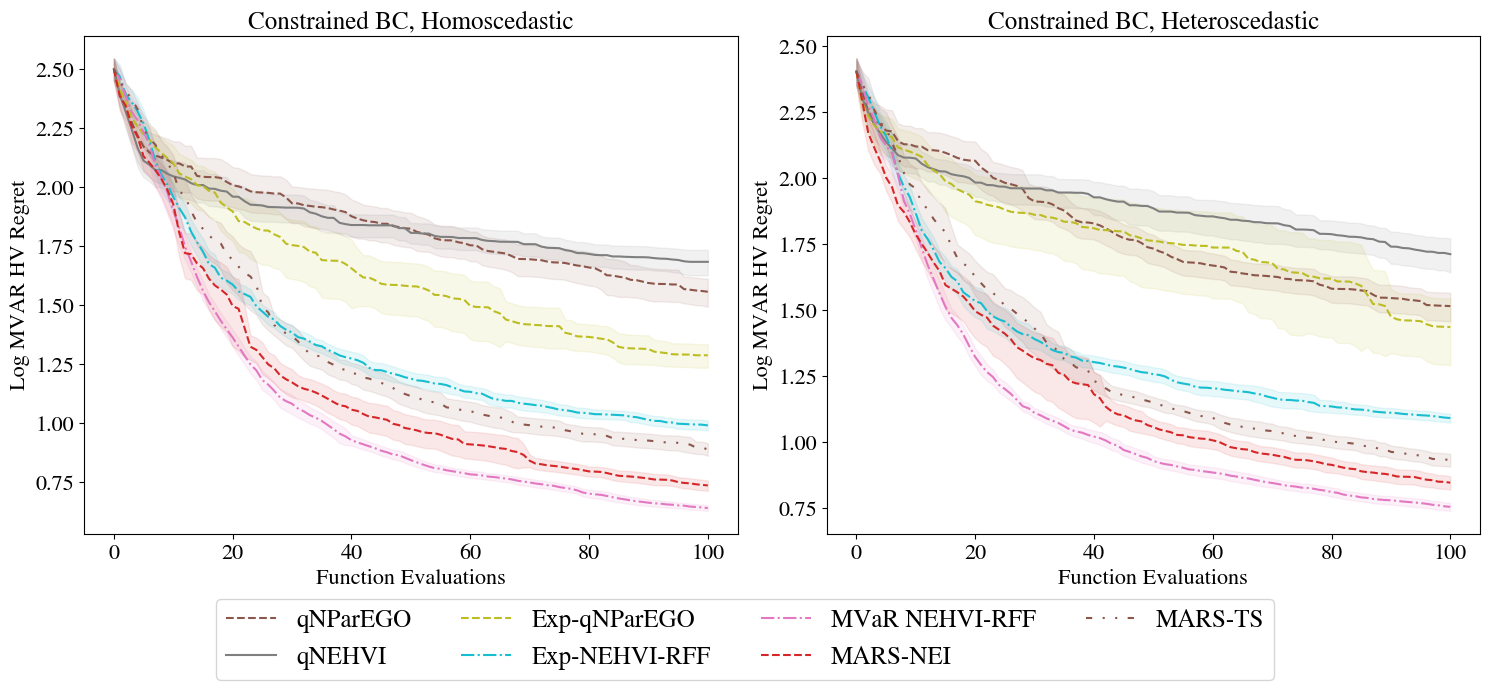

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7),
                         gridspec_kw={})

plot_args = {
    # "sobol": {"label": "Sobol", "color": "tab:pink"},
    "nparego": {"label": "qNParEGO", "color": "tab:brown", "ls": "--"},
    "nehvi": {"label": "qNEHVI", "color": "tab:gray"},
    # "cas": {"label": "Constraint Active Search", "color": "tab:pink"},
    # "nehvi_rff": {"label": "NEHVI-RFF", "color": "tab:gray", "ls": "-."},
    "expectation_nparego": {"label": "Exp-qNParEGO", "color": "tab:olive", "ls": "--"},
    "expectation_nehvi_rff": {"label": "Exp-NEHVI-RFF", "color": "tab:cyan", "ls": "-."},
    "ref_mvar_nehvi_rff": {"label": "MVaR NEHVI-RFF", "color": "tab:pink", "ls": "-."},
    "ref_ch-var-nei": {"label": "MARS-NEI", "color": "tab:red", "ls": "--"},
    # "ch-var-ucb": {"label": "MARS-UCB", "color": "tab:cyan", "ls": ":"},
    "ref_ch-var-ts": {"label": "MARS-TS", "color": "tab:brown", "ls": (0, (3, 5, 1, 5, 1, 5))},
}
labels = list(plot_args.keys())

plot("bc_v2", title="Constrained BC, Homoscedastic", fig=fig, ax=axes[0])
plot("bc_heteroskedastic_v2", title="Constrained BC, Heteroscedastic", fig=fig, ax=axes[1])


h, l = axes[0].get_legend_handles_labels()
leg = fig.legend(
    h,
    l,
    loc="lower center",
    ncol=4,
)

fig.tight_layout(rect=[0, 0.13, 1, 1])
plt.savefig("plots/bc_noise.pdf", dpi=300, transparent=True)
plt.show()
